### Graph-based SIR
To generate the node atomic models, up to a degree of N (for example, 20), run the following command from `random_graphs/nodes_atomic_generator`:

```python model_generator.py -o ../user_models -c ../../cdpp/src -m 20 && make -C ../user_models/```

This will generate the atomic sources for each kind of node, and compile CD++ with them.

In [1]:
from pringles.simulator import Simulator
from pringles.models import Coupled
from pringles.utils import VirtualTime
from pringles.display import ModelDisplay

In [2]:
simulator = Simulator(cdpp_bin_path="user_models/bin", user_models_dir="user_models/")

In [3]:
r = simulator.get_registry()

In [4]:
def build_complete_graph_of_nodes(n, exp_lambda, infection_rate):
    nodes = [r.Node1("node%d" % (i), exp_lambda=exp_lambda, infection_prob=infection_rate) for i in range(n)]
    graph = Coupled("top", nodes)
    for i in range(0,n):
        # Connecting i-th node with all others
        for j in range(0,n):
            if i != j:
                graph.add_coupling(nodes[i].get_port("out0"), nodes[j].get_port("in0"))
    return graph

In [5]:
top = build_complete_graph_of_nodes(99, 3, .25)

In [6]:
ModelDisplay(top)

In [7]:
results = simulator.run_simulation(top, VirtualTime.of_seconds(60))

In [8]:
print(results.logs_dfs.keys())

dict_keys(['node98', 'node97', 'node96', 'node95', 'node94', 'node93', 'node92', 'node91', 'node90', 'node89', 'node88', 'node87', 'node86', 'node85', 'node84', 'node83', 'node82', 'node81', 'node80', 'node79', 'node78', 'node77', 'node76', 'node75', 'node74', 'node73', 'node72', 'node71', 'node70', 'node69', 'node68', 'node67', 'node66', 'node65', 'node64', 'node63', 'node62', 'node61', 'node60', 'node59', 'node58', 'node57', 'node56', 'node55', 'node54', 'node53', 'node52', 'node51', 'node50', 'node49', 'node48', 'node47', 'node46', 'node45', 'node44', 'node43', 'node42', 'node41', 'node40', 'node39', 'node38', 'node37', 'node36', 'node35', 'node34', 'node33', 'node32', 'node31', 'node30', 'node29', 'node28', 'node27', 'node26', 'node25', 'node24', 'node23', 'node22', 'node21', 'node20', 'node19', 'node18', 'node17', 'node16', 'node15', 'node14', 'node13', 'node12', 'node11', 'node10', 'node9', 'node8', 'node7', 'node6', 'node5', 'node4', 'node3', 'node2', 'node1', 'node0', 'top', 'P

In [43]:
import pandas as pd

# Concatenating all nodes external transitions
nodes_external_transitions = pd.concat([results.logs_dfs[node_id] for node_id in results.logs_dfs.keys() if node_id.startswith("node")])
nodes_external_transitions = nodes_external_transitions.sort_values(by=["time"])
nodes_external_transitions

,0,1,message_type,time,model_origin,port,value,model_dest
0,0,L,X,00:00:00:018,top(76),in3,1.0,node63(64)
0,0,L,X,00:00:00:109,top(76),in5,1.0,node38(39)
0,0,L,X,00:00:00:195,top(76),in2,1.0,node49(50)
0,0,L,X,00:00:00:197,top(76),in0,1.0,node71(72)
0,0,L,X,00:00:00:330,top(76),in4,1.0,node17(18)
0,0,L,X,00:00:00:377,top(76),in0,1.0,node59(60)
1,0,L,X,00:00:00:412,top(76),in0,1.0,node59(60)
0,0,L,X,00:00:00:555,top(76),in0,1.0,node67(68)
0,0,L,X,00:00:00:647,top(76),in0,1.0,node27(28)
0,0,L,X,00:00:00:671,top(76),in2,1.0,node70(71)


In [24]:
import matplotlib.pyplot as plt

In [44]:
infections_count = nodes_external_transitions.groupby("time").count()
infections_count = infections_count.drop([0, 1, "message_type", "model_origin", "port", "model_dest"], axis=1)
infections_count = infections_count.rename({"value":"infections_count"}, axis=1)

In [45]:
accum_infections = [0]*len(list(infections_count.infections_count))
for i, c in enumerate(list(infections_count.infections_count)):
    if i == 0:
        accum_infections[i] = c
    else:
        accum_infections[i] = accum_infections[i-1] + c

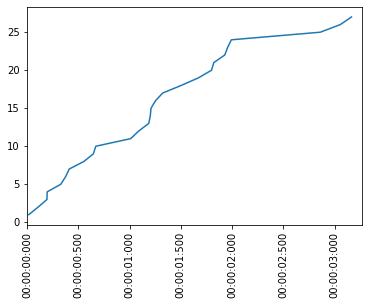

In [46]:
ax = plt.axes()
vtime_indexes = list(infections_count.index)
ax.plot(vtime_indexes, list(accum_infections))
ax.set_xlim(0, max([float(vtime) for vtime in vtime_indexes])+float(VirtualTime.from_number(1000)))
ticks = ax.get_xticks()
ax.set_xticklabels([VirtualTime.from_number(tick) for tick in ticks], rotation=90)
ax

### Configuration model graph generation

In [14]:
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout
import random

In [15]:
# Generating configuration model degree sequence
alpha = 10
beta = 1
node_count = 75
degree_sequence = [int(random.gammavariate(alpha, beta)) for i in range(node_count)]
if sum(degree_sequence) % 2 == 1:
    degree_sequence[-1] += 1

In [16]:
import time
import math
random_seed = int(time.time()*1000) << 2

In [17]:
steffi_graph = nx.configuration_model(degree_sequence, seed=random_seed)

/Users/pbalbi/.pyenv/versions/3.7.1/Python.framework/Versions/3.7/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:563: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/pbalbi/.pyenv/versions/3.7.1/Python.framework/Versions/3.7/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: 
The is_numlike function was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use isinstance(..., numbers.Number) instead.
  if cb.is_numlike(alpha):


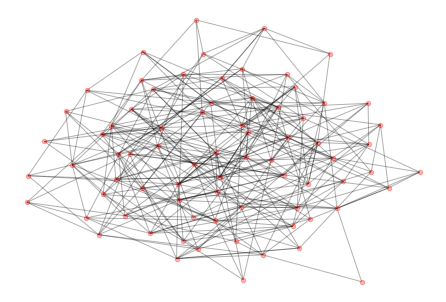

In [18]:
# Drawing graph
pos = graphviz_layout(steffi_graph, root=0)
nx.draw(steffi_graph, pos, with_labels=False, alpha=.3, node_size=20)
plt.show()

In [19]:
from typing import Dict
def build_graph_model_from_nx_graph(graph: nx.Graph, exp_lambda, infection_rate):
    nodes_degrees = [graph.degree(i) for i in range(len(graph.nodes))]
    max_degree = max(nodes_degrees)
    if max_degree > 20:
        raise Exception("Do no have models of degree above 20")
    nodes = [getattr(r,"Node%d" % (degree))("node%d" % (i), exp_lambda=exp_lambda, infection_prob=infection_rate) 
             for i, degree in enumerate(nodes_degrees)]
    graph = Coupled("top", nodes)
    
    _last_out_node = {}
    _last_in_node = {}

    def do_get_last_port(u: int, dic: Dict[int, int], portname: str):
        if u not in dic:
            dic[u] = 0
            return portname + "0"
        else:
            last = dic[u]
            dic[u] = last+1
            return portname + "%d" % (last+1)

    def last_out_node(u):
        return do_get_last_port(u, _last_out_node, "out")
    def last_in_node(u):
        return do_get_last_port(u, _last_in_node, "in")
    
    # Connecting nodes according to graph
    for u,v in steffi_graph.edges():
        graph.add_coupling(nodes[u].get_port(last_out_node(u)), nodes[v].get_port(last_in_node(v)))
    return graph

In [40]:
nx_graph_coupled = build_graph_model_from_nx_graph(steffi_graph, 2, .5)

In [41]:
results = simulator.run_simulation(nx_graph_coupled, VirtualTime.of_minutes(10))

In [42]:
results